# Model based on playlist similarity

Given a playlist, we want to add more tracks to it: it's the **playlist continuation** problem. Following [Kelen et al.](https://dl.acm.org/doi/abs/10.1145/3267471.3267477), the idea here is to define a similarity metric between two playlists, select the $k$ most similar playlists to ours, define a score metric for tracks continuing our playlist and choose the best tracks to continue it.

In [1]:
from scipy.sparse import lil_matrix
from tqdm.notebook import tqdm
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()

In [2]:
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy

auth_manager = SpotifyClientCredentials()
sp = spotipy.Spotify(auth_manager=auth_manager)

## Treatment of data

### Tracks

Here we load and treat the tracks dataset.

In [3]:
def tracks_dfs():
    """Generator to concatenate the various files."""
    for file in glob.glob('../../data/sp_tracks_ready_*.pkl'):
        df = pd.read_pickle(file)[['id', 'playlist_id', 'artists_ids']]
        yield pd.concat([df, pd.DataFrame({'file': [file]*len(df)})], axis=1)

In [ ]:
tracks_df = pd.concat(tqdm(tracks_dfs(), total=128), ignore_index=True)
tracks_df.dropna(inplace=True)

# The following is necessary to discard repeated playlists
tracks_df['idx'] = tracks_df.index
grouped = tracks_df.groupby(
    ['playlist_id', 'file']
)['idx'].apply(list).reset_index()
tracks_df = tracks_df.drop(
    index = [el for list in grouped[grouped.duplicated(
        'playlist_id'
    )].idx for el in list]
)
del grouped
tracks_df.drop(columns='idx', inplace=True)

We treat the playlists dataset:

In [5]:
playlists = tracks_df.groupby('playlist_id')['id'].apply(list)

We treat the artists for each track:

In [6]:
artists = tracks_df.drop_duplicates('id').set_index('id').artists_ids
artists.index.name = 'track_id'
artists_ids = dict(zip(artists.index, range(len(artists))))

## Training, validation and test data

Now we split the data:

In [7]:
def split_data(playlists, test_frac=0.2):
    
    # Only playlists between 5 and 250 tracks
    query = playlists.apply(lambda x: len(x))
    playlists = playlists[(query >= 5) & (query <= 250)]

    # Split training and test data
    n_test = int(np.ceil(len(playlists)*test_frac))
    query = playlists.apply(lambda x: len(x))
    playlists_test = playlists[(query > 25)].sample(n_test)
    playlists_training = playlists.drop(index = playlists_test.index)
    
    return playlists_training, playlists_test

In [8]:
playlists_training, playlists_test = split_data(playlists)

In [9]:
playlists_training, playlists_validation = split_data(playlists_training)

## The model

### Relevance matrix $R$

We build the relevance matrix $R$.

$R_{ij}=r_{ij}$ indicates if a track $j$ is relevant to the playlist $i$, that is, the track is in the playlist.

Because we will use matrix multiplication, we have to index each track ID and each playlist ID to an index of the matrix. We do it here using dictionaries.

In [10]:
def matrix_r(playlists_training):
    """Create relevance matrix R."""
    all_tracks = []
    for playlist in playlists_training.to_list():
        all_tracks.extend(playlist)
    all_tracks = list(set(all_tracks))

    track_ids_go = dict(zip(all_tracks, range(len(all_tracks))))
    track_ids_back = dict(zip(track_ids_go.values(), track_ids_go.keys()))
    playlist_ids = dict(zip(
        set(playlists_training.index), range(len(set(playlists_training.index)))
    ))

    m = len(set(playlists_training.index))
    n = len(set(all_tracks))
    R = lil_matrix((m, n))

    for playlist_id, playlist in playlists_training.iteritems():
        for track_id in playlist:
            R[playlist_ids[playlist_id], track_ids_go[track_id]] = 1
            
    return track_ids_go, track_ids_back, playlist_ids, R

### Similarity

The similarity between two playlists $u$ and $v$ is calculated by:
$$s_{uv} = \sum_{i \in I} \dfrac{r_{ui}r_{vi}}{||R_u||_2||R_v||_2}$$
$I$ is the set of tracks and $R_u$ is the vector of relevances $r_{ui}$ for the playlist $u$.

In fact, we basically count the number of tracks in the intersection of the playlists and normalize it.

In [11]:
def similarity(playlist_1, playlist_2):
    """Calculate the similarity between two playlists."""
    summation = len(set(playlist_1) & set(playlist_2))
    if summation == 0:
        return 0
    return summation/np.sqrt(len(playlist_1)*len(playlist_2))

### Track score

Given a playlist $u$ to be continuated, we calculate the similarity of it with all existent playlists and select the $k$ most similar playlists, that is, the set $N_k(u)$. So, we define a score for a track to be in the playlist:
$$\hat{r}_{ui} = \dfrac{\sum_{v \in N_k(u)} s_{uv} \cdot r_{vi}}{\sum_{v \in N_k(u)} s_{uv}}$$

The intuition is that we are giving high scores to tracks that are in many playlists with great similarities to our playlist. We return the tracks ordered by score.

In [12]:
def continuation(R, playlist, playlists_training, k, playlist_ids, track_ids_back):
    """Continue a playlist based on k most similar playlists."""
    m = len(set(playlists_training.index))
    s_u = lil_matrix((1, m))
    for alt_playlist_index, alt_playlist in playlists_training.items():
        s = similarity(playlist, alt_playlist)
        s_u[0, playlist_ids[alt_playlist_index]] = s
    sorted_similarities_indices = np.flip(np.argsort(s_u.toarray()[0]))
    top_k_similarities_indices = sorted_similarities_indices[:k]
    scores = s_u[0, top_k_similarities_indices]*R[top_k_similarities_indices, :]
    scores = scores.toarray()[0]
    sorted_scores_indices = np.flip(np.argsort(scores)[-225:])
    return [track_ids_back[index] for index in sorted_scores_indices]

### Summary

- We choose a playlist to be continuated;
- We calculate the similarity between this and each playlist in the training dataset;
- We calculate the score of each track continuating our playlist;
- We choose the tracks with highest score.

## Evaluation

### R-precision metric

As described in their work, [Chen et al.](https://dl.acm.org/doi/10.1145/3240323.3240342) suggest a metric for playlist continuation playlist evaluation. They call it **R-precision**. It measures how many of the real tracks (and their artists) the model correctly suggested.

A playlist as input to the model has two parts: the part the model will see and the part the model will try to predict, called *ground truth*.

$$\textrm{R-precision} = \dfrac{|S_T \cap G_T| + 0.25 \cdot |S_A \cap G_A|}{|G_T|}$$

$G_T$ is the set of unique track IDs from ground truth, that is, the unique hidden tracks. $S_T$ is the suggested tracks from our model. $G_A$ is the set of unique artists IDs from ground truth and $S_A$ is the set of predicted artists. The metric can be interpreted as accuracy (although it can be greater than 1), but giving some score for wrong tracks with right artists.

In [13]:
def r_precision(S_t, G_t, S_a, G_a):
    return (len(set(S_t) & set(G_t)) + 0.25 * len(set(S_a) & set(G_a))) / len(G_t)

In [14]:
def evaluation(playlist_not_hidden, playlist_hidden, continuation):
    for track in playlist_not_hidden:
        if track in continuation:
            continuation.remove(track)
    continuation = continuation[:len(playlist_hidden)]
    
    G_a = []
    for track in playlist_hidden:
        G_a.extend(artists.iloc[artists_ids[track]])
    S_a = []
    for track in continuation:
        S_a.extend(artists.iloc[artists_ids[track]])
        
    metric = r_precision(continuation, playlist_hidden, S_a, G_a)
    return metric

### Hyperparameter $k$

We now select a $k$ value that maximizes the R-precision metric in a sample in our validation dataset. It's not feasible to select $k$ by cross-validation, because we need test data to have more than 25 tracks.

In [ ]:
track_ids_go, track_ids_back, playlist_ids, R = matrix_r(playlists_training)
metrics = []
for k in tqdm([1, 10, 100, 4000, 10000, len(playlists_training)]):
    metric_summation = 0
    for playlist in tqdm(playlists_validation.sample(1000)):
        playlist_not_hidden = playlist[:25]
        playlist_hidden = playlist[25:]
        continuated = continuation(
            R, playlist_not_hidden, playlists_training,
            k, playlist_ids, track_ids_back
        )
        metric = evaluation(playlist_not_hidden, playlist_hidden, continuated)
        metric_summation += metric
    metrics.append(metric_summation/1000)

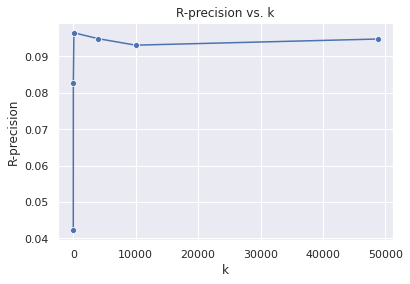

In [16]:
sns.lineplot(
    x=[1, 10, 100, 4000, 10000, len(playlists_training)],
    y=metrics,
    marker='o'
)
plt.title('R-precision vs. k')
plt.xlabel('k')
plt.ylabel('R-precision')
plt.show()

In [17]:
k = [1, 10, 100, 4000, 10000, len(playlists_training)][np.argmax(metrics)]
print('The best k is {}.'.format(k))

The best k is 100.


Now we train and evaluate our model:

In [ ]:
playlists_all_training = pd.concat([playlists_training, playlists_validation])
track_ids_go, track_ids_back, playlist_ids, R = matrix_r(playlists_all_training)
metric_summation = 0
for playlist in tqdm(playlists_test):
    playlist_not_hidden = playlist[:25]
    playlist_hidden = playlist[25:]
    continuated = continuation(
        R, playlist_not_hidden, playlists_all_training,
        k, playlist_ids, track_ids_back
    )
    metric = evaluation(playlist_not_hidden, playlist_hidden, continuated)
    metric_summation += metric

In [19]:
print('R-precision = {:.4f}'.format(metric_summation/len(playlists_test)))

R-precision = 0.1107


As said by [Chen et al.](https://dl.acm.org/doi/10.1145/3240323.3240342), the highest performance achieved in *RecSys Challenge 2018* was 0.2241. Well, many competitors were using much more advanced models, like neural networks, and they also had much more data and possible more computational power. So the results we achieved seems much reasonable.

## Use case

We will take the most listened songs from Michael jackson and continue the playlist, with $k = 100$.

In [30]:
q = sp.search('michael jackson', type='artist')

Our playlist to be continuated:

In [31]:
temp = [track['name'] for track in sp.artist_top_tracks(q['artists']['items'][0]['id'])['tracks']]
temp

['Billie Jean',
 'Beat It - Single Version',
 'Smooth Criminal - 2012 Remaster',
 "Don't Stop 'Til You Get Enough - Single Version",
 'Don’t Matter To Me (with Michael Jackson)',
 'The Way You Make Me Feel - 2012 Remaster',
 'Rock with You - Single Version',
 "They Don't Care About Us",
 'P.Y.T. (Pretty Young Thing)',
 'Remember the Time']

Continuating...

In [33]:
temp = [track['id'] for track in sp.artist_top_tracks(q['artists']['items'][0]['id'])['tracks']]
result = continuation(R, temp, playlists_all_training, k, playlist_ids, track_ids_back)

In [34]:
q = sp.tracks(result[:50])

In [35]:
[(q['tracks'][i]['name'], q['tracks'][i]['artists'][0]['name']) for i in range(len(q['tracks']))][:25]

[('Billie Jean', 'Michael Jackson'),
 ('Beat It - Single Version', 'Michael Jackson'),
 ('Smooth Criminal - 2012 Remaster', 'Michael Jackson'),
 ('Rock with You - Single Version', 'Michael Jackson'),
 ("Don't Stop 'Til You Get Enough - Single Version", 'Michael Jackson'),
 ('P.Y.T. (Pretty Young Thing)', 'Michael Jackson'),
 ('The Way You Make Me Feel - 2012 Remaster', 'Michael Jackson'),
 ('Remember the Time', 'Michael Jackson'),
 ('Bad - 2012 Remaster', 'Michael Jackson'),
 ('Man in the Mirror - 2012 Remaster', 'Michael Jackson'),
 ('Human Nature', 'Michael Jackson'),
 ("They Don't Care About Us", 'Michael Jackson'),
 ('Thriller', 'Michael Jackson'),
 ('Sweet Dreams (Are Made of This) - Remastered', 'Eurythmics'),
 ("Wanna Be Startin' Somethin'", 'Michael Jackson'),
 ('Black or White', 'Michael Jackson'),
 ("I Just Can't Stop Loving You (feat. Siedah Garrett) - 2012 Remaster",
  'Michael Jackson'),
 ('Dirty Diana - 2012 Remaster', 'Michael Jackson'),
 ('Take on Me', 'a-ha'),
 ('Off t

Well, it seems nice.